# Prepare simulation data

In [1]:
import os
import glob
import pickle

import collections

import numpy as np
import scipy.ndimage

import pyccl as ccl

%matplotlib inline
import matplotlib.pyplot as plt


from cosmotools.plotting import subplot_colorbar
import cosmotools.utils as utils

import baryon_painter.utils.datasets as datasets

pi = np.pi

### Calculate comoving sizes of SLICS lightcone mass sheets

In [2]:
n_grid_BAHAMAS = 2048
L_BAHAMAS = 400

pixel_size_phys_BAHAMAS = L_BAHAMAS/n_grid_BAHAMAS

SLICS_filenames = glob.glob("../data/training_data/SLICS/delta/*delta.dat_bicubic_LOS299")

z_SLICS = [float(z[:z.find("delta")]) for z in [os.path.split(f)[1] for f in SLICS_filenames]]
z_SLICS = np.array(sorted(z_SLICS))

n_grid_SLICS = 7745
theta_SLICS = 10/180*pi

pixel_size_ang_SLICS = theta_SLICS/n_grid_SLICS


Omega_m = 0.2905
Omega_b = 0.0473
Omega_L = 0.7095
h = 0.6898
sigma_8 = 0.826
n_s = 0.969
cosmo = ccl.Cosmology(Omega_c=(1-Omega_L-Omega_b), Omega_b=Omega_b, Omega_k=0,
                      h=h, sigma8=sigma_8, n_s=n_s)

d_A_SLICS = ccl.comoving_angular_distance(cosmo, 1/(1+z_SLICS))*h # units of Mpc/h

pixel_size_phys_SLICS = pixel_size_ang_SLICS*d_A_SLICS

beam_Planck = 10/60/180*pi

print(f"pixel size BAHAMAS (Mpc / h): {pixel_size_phys_BAHAMAS:.2f}")
print()
print("z        pixel size SLICS (Mpc / h)    scaled n_pixel     Beam size Planck (Mpc / h)")
for z, d_A, p in zip(z_SLICS, d_A_SLICS, pixel_size_phys_SLICS):
    s = pixel_size_phys_BAHAMAS/p
    print(f"{z:.3f}              {p:.4f}                {n_grid_SLICS/s:6.1f}             {d_A*beam_Planck:6.2f}")

pixel size BAHAMAS (Mpc / h): 0.20

z        pixel size SLICS (Mpc / h)    scaled n_pixel     Beam size Planck (Mpc / h)
0.042              0.0028                 111.5               0.36
0.130              0.0085                 338.1               1.10
0.221              0.0142                 562.4               1.83
0.317              0.0199                 787.7               2.56
0.418              0.0255                1012.2               3.29
0.525              0.0312                1236.4               4.02
0.640              0.0369                1462.2               4.76
0.764              0.0426                1689.2               5.50
0.897              0.0483                1915.0               6.23
1.041              0.0540                2140.5               6.97
1.199              0.0597                2367.6               7.71
1.372              0.0654                2594.4               8.45
1.562              0.0711                2820.5               9.18
1.772   

The physical size of the Planck beam (assuming 10 arcmin, which is overestimating it) at the lowest redshift slice (z = 0.042) is larger than the BAHAMAS pixel size (assuming 1024 grids). We should therefore move to 2048 grids for BAHAMAS.

In [37]:
d_A_SLICS*10/180*pi

array([ 21.77289306,  66.04365283, 109.84830539, 153.84825741,
       197.697986  , 241.48144097, 285.5942848 , 329.93113006,
       374.02564268, 418.07151683, 462.41309736, 506.7112455 ,
       550.87041767, 594.9417124 , 639.21982146, 683.2874715 ,
       727.47174576, 771.44956095])

# BAHAMAS sheet combination strategy

The SLICS mass sheets are 252.5 Mpc $h^{-1}$ deep, which is $\approx 5\times 50$ Mpc h$^{-1}$. To retain as much line-of-sight correlation as possible while ensuring sufficent number of training samples, we split the boxes into $3\times 50$ Mpc h$^{-1}$ and $2\times 50$ Mpc h$^{-1}$ slices that can be combined arbitrarily to give $5\times 50$ Mpc h$^{-1}$ slices.

We split 
- six projections into two 150 Mpc h$^{-1}$ slices and one 100 Mpc h$^{-1}$ slice, 
- two projections into one 150 Mpc h$^{-1}$ slices and two 100 Mpc h$^{-1}$ slice, 
- one projecction into four 100 Mpc h$^{-1}$ slices,

for a total of 14 of both 150 Mpc h$^{-1}$ and 100 Mpc h$^{-1}$ slices. These slices are split into $4\times 4=16$ slices, such that the total number of combinations that can be made is $(14\cdot 16)^2=50176$, which should be sufficient for our purposes.

The last volume is used for testing and validation. It is split into
- two projections into two 150 Mpc h$^{-1}$ slices and one 100 Mpc h$^{-1}$ slice, 
- one projections into one 150 Mpc h$^{-1}$ slices and two 100 Mpc h$^{-1}$ slice, 

for five 150 Mpc h$^{-1}$ and four 100 Mpc h$^{-1}$ slices, which can be combined into $(5\cdot 16)(4\cdot 16)=5120$ 250 Mpc h$^{-1}$ equivalent slices.

We're using `numpy.save` instead of `numpy.savez` because the latter is very slow at access time (something about lazy loading of the file).

In [283]:
stack_slices = {  # 3 x (2 x 150Mpc/h + 1 x 100 Mpc/h)
                  "v1" : {"x" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "y" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "z" : (slice(0, 3), slice(3,6), slice(6,8))},
                  # 3 x (2 x 150Mpc/h + 1 x 100 Mpc/h)
                  "v2" : {"x" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "y" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "z" : (slice(0, 3), slice(3,6), slice(6,8))},
                  # 2 x (1 x 150Mpc/h + 2 x 100 Mpc/h) + 1 x (4 x 100 Mpc/h)
                  "v3" : {"x" : (slice(0, 3), slice(3,5), slice(5,7)),
                          "y" : (slice(0, 3), slice(3,5), slice(5,7)),
                          "z" : (slice(0, 2), slice(2,4), slice(4,6), slice(6,8))},
                  # Test & validation volume: 2 x (2 x 150Mpc/h + 1 x 100 Mpc/h) + 1 x (1 x 150Mpc/h + 2 x 100 Mpc/h) 
                  "v4" : {"x" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "y" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "z" : (slice(0, 3), slice(3,5), slice(5,7)),},
                }

test_volumes = ["v4"]

z2snap = {0.0 : 32,
          0.5 : 28,
          1.0 : 26,
          2.0 : 22,}


n_sheet = 8 # Sheets in cube
n_stack = 14
n_grid = 2048

slices_100Mpc = []
slices_150Mpc = []

test_slices_100Mpc = []
test_slices_150Mpc = []


filename_template = "../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_{volume}_L400N1024_WMAP9_snap{snap}_{field}_sheets"

out_path = "../data/training_data/BAHAMAS/stacks_uncompressed/"
out_filename_template = "{field}_z{z:.1f}_train"
test_out_filename_template = "{field}_z{z:.1f}_test"

info_dicts = []
info_test_dicts = []

for field in ["dm", "gas", "pressure", "stars"]:
    print(f"Processing {field}.")
    for redshift in [0.0, 0.5, 1.0, 2.0]:
        print(f" -> Processing z = {redshift:.1f}")
        slices_100Mpc = []
        slices_150Mpc = []
        test_slices_100Mpc = []
        test_slices_150Mpc = []

        for v in ["v1", "v2", "v3", "v4"]:
            print(f"     -> Processing {v}")
            
            filename = filename_template.format(volume=v, field=field, snap=z2snap[redshift])
            print(f"Reading {filename}.")
            data = np.fromfile(filename, dtype=np.float32)
            data = data.reshape(3, n_sheet, n_grid, n_grid, order="F")
            
            for i, projection in enumerate(["x", "y", "z"]):
                for s in stack_slices[v][projection]:
                    stack = data[i][s]
                    if v in test_volumes:
                        if stack.shape[0] == 3:
                            test_slices_150Mpc.append(stack.sum(axis=0))
                        elif stack.shape[0] == 2:
                            test_slices_100Mpc.append(stack.sum(axis=0))
                        else:
                            raise RuntimeError(f"Illegal stack size {stack.shape[0]}")
                    else:
                        if stack.shape[0] == 3:
                            slices_150Mpc.append(stack.sum(axis=0))
                        elif stack.shape[0] == 2:
                            slices_100Mpc.append(stack.sum(axis=0))
                        else:
                            raise RuntimeError(f"Illegal stack size {stack.shape[0]}")
                        
        slices_100Mpc = np.array(slices_100Mpc)
        slices_150Mpc = np.array(slices_150Mpc)
        
        mean_100 = slices_100Mpc.mean()
        var_100 = slices_100Mpc.var(ddof=1)
        mean_150 = slices_150Mpc.mean()
        var_150 = slices_150Mpc.var(ddof=1)
        
        test_slices_100Mpc = np.array(test_slices_100Mpc)
        test_slices_150Mpc = np.array(test_slices_150Mpc)
        
        test_mean_100 = test_slices_100Mpc.mean()
        test_var_100 = test_slices_100Mpc.var(ddof=1)
        test_mean_150 = test_slices_150Mpc.mean()
        test_var_150 = test_slices_150Mpc.var(ddof=1)
        
        out_filename = out_filename_template.format(field=field, z=redshift)
        print(f"Writing to {out_filename}")
        np.save(os.path.join(out_path, out_filename+"_100"), slices_100Mpc)
        np.save(os.path.join(out_path, out_filename+"_150"), slices_150Mpc)
        
        info = {"field"    : field,
                "z"        : redshift,
                "n_grid"   : n_grid,
                "n_sheet"  : n_sheet,
                "n_stack"  : n_stack,
                "mean_100" : mean_100,
                "mean_150" : mean_150,
                "var_100"  : var_100,
                "var_150"  : var_150,
                "file_100" : out_filename+"_100.npy",
                "file_150" : out_filename+"_150.npy"}
        info_dicts.append(info)
        
        test_out_filename = test_out_filename_template.format(field=field, z=redshift)
        print(f"Writing to {test_out_filename}")
        np.save(os.path.join(out_path, test_out_filename+"_100"), test_slices_100Mpc)
        np.save(os.path.join(out_path, test_out_filename+"_150"), test_slices_150Mpc)
        
        info_test = {"field"    : field,
                     "z"        : redshift,
                     "n_grid"   : n_grid,
                     "n_sheet"  : n_sheet,
                     "n_stack"  : n_stack,
                     "mean_100" : test_mean_100,
                     "mean_150" : test_mean_150,
                     "var_100"  : test_var_100,
                     "var_150"  : test_var_150,
                     "file_100" : test_out_filename+"_100.npy",
                     "file_150" : test_out_filename+"_150.npy"}
        info_test_dicts.append(info_test)

with open(os.path.join(out_path, "train_files_info.pickle"), "wb") as f:        
    pickle.dump(info_dicts, f)
with open(os.path.join(out_path, "test_files_info.pickle"), "wb") as f:        
    pickle.dump(info_test_dicts, f)
  
    
    

Processing dm.
 -> Processing z = 0.0
     -> Processing v1
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap32_dm_sheets.
     -> Processing v2
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v2_L400N1024_WMAP9_snap32_dm_sheets.
     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap32_dm_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v4_L400N1024_WMAP9_snap32_dm_sheets.
Writing to dm_z0.0_train
Writing to dm_z0.0_test
 -> Processing z = 0.5
     -> Processing v1
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap28_dm_sheets.
     -> Processing v2
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v2_L400N1024_WMAP9_snap28_dm_sheets.
     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap28_dm_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAM

     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap26_stars_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v4_L400N1024_WMAP9_snap26_stars_sheets.
Writing to stars_z1.0_train
Writing to stars_z1.0_test
 -> Processing z = 2.0
     -> Processing v1
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap22_stars_sheets.
     -> Processing v2
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v2_L400N1024_WMAP9_snap22_stars_sheets.
     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap22_stars_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v4_L400N1024_WMAP9_snap22_stars_sheets.
Writing to stars_z2.0_train
Writing to stars_z2.0_test


## Dataset and dataloader

Check the dataloader and pickling of the transforms.

In [397]:
with open("../data/training_data/BAHAMAS/stacks_uncompressed/train_files_info.pickle", "rb") as f:
    training_files_info = pickle.load(f)

import baryon_painter.utils.data_transforms as data_transforms

importlib.reload(datasets)
importlib.reload(data_transforms)

scale_split_transform, scale_split_inv_transform = data_transforms.create_split_scale_transform(n_scale=2, 
                                                                                step_size=8, 
                                                                                include_original=False)

dataset = datasets.BAHAMASDataset(training_files_info, root_path="../data/training_data/BAHAMAS/stacks_uncompressed/",
                                  transform=scale_split_transform,
                                  inverse_transform=scale_split_inv_transform,
                                  scale_to_SLICS=True
                                 )

s, idx = dataset[124]


In [374]:
import dill

with open("../output/test/transform.pickle", "wb") as f:
    dill.dump(datasets.compile_transform(dataset.transform, dataset.stats), f)

# Check histograms between SLICS and BAHAMAS

The SLICS mass-planes correspond to the sum of particles along the projection direction of the half-box, up to a factor of ~8. I.e., for a mass-plane $m_{ij}$, we have $\frac{1}{8}\sum_{ij} m_{ij} = \frac{1536^3}{2}$. The corresponding $\delta$-planes are built by taking the cut-out from $m_{ij} - \bar m_{ij}$, i.e., the mean-subtracted mass-plane.

The BAHAMAS stacks correspond to the mass-weighted sum of particles in 250 Mpc/$h$ slices, divided by the average mass per cell (NB, that is total mass, i.e., dark matter + gas). I.e., for $n_c = 2048$ cells per dimension, $d_{ij} = \frac{1}{\bar M}\sum_k^{\frac{5}{8}n_c} M_{dm} n_{ijk}$, where $\bar M = \rho_c\Omega_m \frac{L^3}{n_c^3}$ is the mean mass per cell, and $M_{dm}$ the mass per dark matter particle. Since $\bar M \frac{\Omega_c}{\Omega_m}n_c^3 = M_{dm} 1024^3$, we have $d_{ij} = \frac{\Omega_c}{\Omega_m}\frac{n_c^3}{1024^3} \sum_k^{\frac{5}{8}n_c} n_{ijk}$.

We match the SLICS $\delta$-planes and BAHAMAS dark matter stacks by considering the line-of-sight number density contrast defined as
- **BAHAMAS**: $\delta_{ij} = \frac{\Omega_m}{\Omega_c}\frac{1}{\frac{5}{8}n_c}(d_{ij} - \bar d_{ij}$), where $\bar d_{ij}$ is the mean over the whole stack
- **SLICS mass-planes**: $\delta_{ij} = \frac{1}{8}\frac{12288^2}{\frac{1536^3}{2}}(m_{ij} - \bar m_{ij})$. The factor of $\frac{12288^3}{\frac{1536^3}{2}}$ is the average number of particles per pixel.
- **SLICS $\delta$-planes**: $\delta_{ij} = \frac{1}{8}\frac{12288^2}{\frac{1536^3}{2}}\delta^{SLICS}_{ij}$

Units of SLICS mass-planes:

In [315]:
d = np.fromfile(f"../data/training_data/SLICS/massplanes/0.042proj_half_finer_xy.dat_LOS1097", 
                dtype=np.float32)[1:].reshape(4096*3, -1).T
print(f"Sum of mass-plane times 1/8:              {d.sum()/8:.3e}")
print(f"Expected number of particles in half-box: {(1536**3/2):.3e}")
print(f"Fractional difference:                    {d.sum()/8 / (1536**3/2)-1:.3f}")

Sum of mass-plane times 1/8:              1.837e+09
Expected number of particles in half-box: 1.812e+09
Fractional difference:                    0.014


Units of BAHAMAS dark matter slices:

In [349]:
d = np.fromfile(f"../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap32_dm_sheets", 
                dtype=np.float32).reshape(3, 8, 2048, 2048, order="F")
print(f"Number of particles in 50 Mpc/h slice:          {d[0,1].sum()*(1024**3/2048**3)/dm_fraction:.3e}")
print(f"Expected number of particles in 50 Mpc/h slice: {1024**3/8:.3e}")
print(f"Fractional difference:                          {d[0,1].sum()*8*(1/2048**3)/dm_fraction-1:.3f}")

Number of particles in 50 Mpc/h slice:          1.355e+08
Expected number of particles in 50 Mpc/h slice: 1.342e+08
Fractional difference:                          0.009


# Match histograms between BAHAMAS and SLICS

In [364]:
def accumulate_BAHAMAS(bins, dataset, indicies, scaling=1, shift=0, z=0.0, density=True):
    hist = np.zeros(len(bins)-1)
    for idx in indicies:
        d = dataset.get_input_sample(idx, transform=False)
#         d -= dataset.stats["dm"][z]["mean"]
        h, _ = np.histogram(d.flatten()*scaling+shift, bins=bins)
        hist += h
        
    if density:
        hist /= np.trapz(hist, bins[:-1])
    return hist

def accumulate_SLICS(bins, files, mode="masssheet", scaling=1, shift=0, delta_size=None,
                     downsampling_mode="rebin", rebin_factor_rounding="nearest", zoom_order=3,
                     density=True):
    hist = np.zeros(len(bins)-1)
    for f in files:
        if mode == "masssheet":
            target_size = int(2048*505/400)
            zoom_factor = target_size/(4096*3)
            
            d = np.fromfile(f, dtype=np.float32)[1:].reshape(4096*3, -1).T
            d -= d.mean()

        elif mode == "delta":
            if not isinstance(delta_size, float):
                raise ValueError("delta_size needs to be a float.")
            d = np.fromfile(f, dtype=np.float32).reshape(7745, -1).T

            target_size = int(2048*delta_size/400)
            zoom_factor = target_size/7745
        else:
            raise ValueError(f"Mode '{mode}' not supported.")
            
        print(f"zoom factor: {1/zoom_factor}")
        if downsampling_mode == "zoom":
            d = scipy.ndimage.zoom(d, zoom=zoom_factor, mode="wrap", order=zoom_order)
        elif downsampling_mode == "rebin":
            if rebin_factor_rounding == "nearest":
                rebin_factor = round(1/zoom_factor)
            elif rebin_factor_rounding == "ceil":
                rebin_factor = int(np.ceil(1/zoom_factor))
                
            if d.shape[0]%rebin_factor != 0:
                target_size = d.shape[0] - d.shape[0]%rebin_factor
                d = utils.rebin_2d(d[:target_size,:target_size], 
                                   (target_size//rebin_factor, target_size//rebin_factor))
            else:
                d = utils.rebin_2d(d, (d.shape[0]//rebin_factor, d.shape[0]//rebin_factor))
        elif downsampling_mode is None:
            print("No downsampling.")
        else:
            raise ValueError(f"Downsampling mode '{mode}' not supported.")

        h, _ = np.histogram(d.flatten()*scaling+shift, bins=bins)
        hist += h
            
    if density:
        hist /= np.trapz(hist, bins[:-1])
    return hist

dm_fraction = cosmo.params.parameters.Omega_c/cosmo.params.parameters.Omega_m

bins = np.linspace(-1, 3, 501, endpoint=True)

BAHAMAS_dm_hist = accumulate_BAHAMAS(bins, dataset, 
                                     indicies=np.random.randint(dataset.n_sample*2, dataset.n_sample*3,size=40), 
#                                      scaling=1/(256*5)/dm_fraction, 
                                     z=1.0)

SLICS_dm_sheet_hist = accumulate_SLICS(bins, 
                                       files=[#"../data/training_data/SLICS/massplanes/2.007proj_half_finer_xy.dat_LOS1097",
                                              "../data/training_data/SLICS/massplanes/1.041proj_half_finer_xy.dat_LOS1097",
#                                              "../data/training_data/SLICS/massplanes/0.525proj_half_finer_xy.dat_LOS1097",
#                                               f"../data/training_data/SLICS/massplanes/0.042proj_half_finer_xy.dat_LOS1097",
#                                               f"../data/training_data/SLICS/massplanes/0.130proj_half_finer_xz.dat_LOS1097",
#                                               f"../data/training_data/SLICS/massplanes/0.130proj_half_finer_yz.dat_LOS1097"
                                             ],
                                       mode="masssheet",
                                       scaling=1/8/(1536**3/2/12288**2),
                                       downsampling_mode="rebin", 
                                       zoom_order=5)

SLICS_dm_delta_hist = accumulate_SLICS(bins, 
                                       files=[#"../data/training_data/SLICS/delta/2.007delta.dat_bicubic_LOS1097",
                                              #"../data/training_data/SLICS/delta/2.007delta.dat_bicubic_LOS299",
                                              f"../data/training_data/SLICS/delta/1.041delta.dat_bicubic_LOS1097",
                                              f"../data/training_data/SLICS/delta/1.041delta.dat_bicubic_LOS299",
#                                               "../data/training_data/SLICS/delta/0.525delta.dat_bicubic_LOS1097",
#                                               "../data/training_data/SLICS/delta/0.525delta.dat_bicubic_LOS299",
#                                               "../data/training_data/SLICS/delta/0.130delta.dat_bicubic_LOS1097",
#                                               "../data/training_data/SLICS/delta/0.130delta.dat_bicubic_LOS299",
                                             ],
                                       mode="delta",
                                       delta_size=d_A_SLICS[9]*10/180*pi,
                                       scaling=1/8/(1536**3/2/12288**2),
                                       downsampling_mode="rebin",
                                       zoom_order=1)

zoom factor: 4.7535783365570605
zoom factor: 3.619158878504673
zoom factor: 3.619158878504673


Text(0.5,0.98,'Histogram, z=1.0')

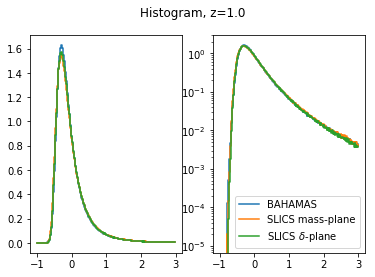

In [365]:
fig, ax = plt.subplots(1, 2)


ax[0].step(bins[:-1], BAHAMAS_dm_hist, label="BAHAMAS")
ax[0].step(bins[:-1], SLICS_dm_sheet_hist, label="SLICS mass-plane")
ax[0].step(bins[:-1], SLICS_dm_delta_hist, label=r"SLICS $\delta$-plane")

ax[1].step(bins[:-1], BAHAMAS_dm_hist, label="BAHAMAS")
ax[1].step(bins[:-1], SLICS_dm_sheet_hist, label="SLICS mass-plane")
ax[1].step(bins[:-1], SLICS_dm_delta_hist, label=r"SLICS $\delta$-plane")
ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Histogram, z=1.0")

In [360]:
print(np.average(bins[:-1], weights=BAHAMAS_dm_hist))
print(np.average(bins[:-1], weights=SLICS_dm_sheet_hist))
print(np.average(bins[:-1], weights=SLICS_dm_delta_hist))

-0.027933212197409032
-0.026434907971231835
-0.026000028943947873


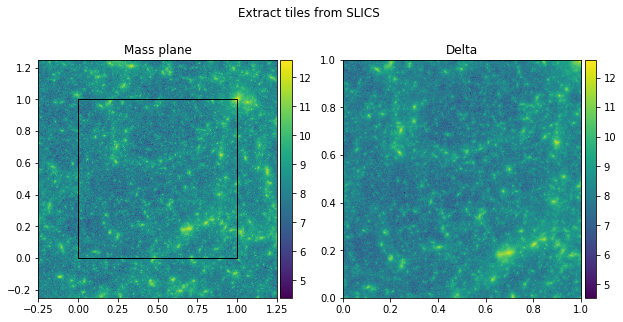

In [3]:
from baryon_painter.process_SLICS import get_tile

def check_get_tile():
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    import pyccl as ccl
    import cosmotools.plotting as plotting
    
    # WMAP9
    Omega_m = 0.2905
    Omega_b = 0.0473
    Omega_L = 0.7095
    h = 0.6898
    sigma_8 = 0.826
    n_s = 0.969
    cosmo = ccl.Cosmology(Omega_c=(1-Omega_L-Omega_b), Omega_b=Omega_b, Omega_k=0,
                          h=h, sigma8=sigma_8, n_s=n_s)

    z_SLICS = 0.042
    d_A_SLICS = ccl.comoving_angular_distance(cosmo, 1/(1+z_SLICS))*h # units of Mpc/h

    
    shifts = np.loadtxt("../data/training_data/SLICS/random_shift_LOS1097")[::-1]

    tile_relative_size = d_A_SLICS*10/180*pi/505

    plane = np.fromfile(f"../data/training_data/SLICS/massplanes/{z_SLICS:.3f}proj_half_finer_xy.dat_LOS1097", dtype=np.float32)[1:].reshape(4096*3, -1).T
    plane *= 64
    plane -= plane.min()

    delta = np.fromfile(f"../data/training_data/SLICS/delta/{z_SLICS:.3f}delta.dat_bicubic_LOS1097", dtype=np.float32).reshape(7745, -1).T
    delta *= 64
    delta -= delta.min()
    delta = delta[::7, ::7]

    expansion_factor = 1.5
    tile = get_tile(plane, shifts[0], tile_relative_size, expansion_factor=expansion_factor)

    delta_region = patches.Rectangle(xy=(0,0), width=1, height=1, fill=False)

    # Plot stuff
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    im = ax[0].imshow(np.log(tile+1), extent=(-(expansion_factor-1)/2, 1.0+(expansion_factor-1)/2, 
                                              -(expansion_factor-1)/2, 1.0+(expansion_factor-1)/2))
    plotting.subplot_colorbar(im, ax[0])
    ax[0].add_artist(delta_region)

    im = ax[1].imshow(np.log(delta+1), extent=(0.0, 1.0, 0.0, 1.0))
    plotting.subplot_colorbar(im, ax[1])
    
    ax[0].set_title("Mass plane")
    ax[1].set_title("Delta")
    fig.suptitle("Extract tiles from SLICS")
    
check_get_tile()

# Painter pipeline

In [4]:


import baryon_painter.painter
# import baryon_painter.utils.datasets as datasets

import importlib
importlib.reload(baryon_painter.painter)

painter = baryon_painter.painter.CVAEPainter(("../data/checkpoints/scale_split_fixed_var_noz2_adalr_net2_new_transform_sample100352_state",
                                              "../data/checkpoints/scale_split_fixed_var_noz2_adalr_net2_new_transform_sample100352_meta"))


n_scale = 2
label_fields = ["pressure"]
redshifts = [0.0, 0.5, 1.0]

# split_scale_transform, inv_split_scale_transform = data_transforms.create_split_scale_transform(n_scale=n_scale, step_size=8, include_original=False)

# range_compress_transform, range_compress_inv_transform = data_transforms.create_range_compress_transforms(k_values={"dm" : 2, "gas" : 2, "pressure" : 4})

# with open(os.path.join("../data/training_data/BAHAMAS/stacks_uncompressed/test_files_info.pickle"), "rb") as f:
#     test_files_info = pickle.load(f)


# transform = data_transforms.chain_transformations([range_compress_transform,
#                                    split_scale_transform,
#                                    data_transforms.atleast_3d,
#                                   ])

# inv_transform = data_transforms.chain_transformations([data_transforms.squeeze,
#                                        inv_split_scale_transform,
#                                        range_compress_inv_transform,
#                                       ])

# test_tiling_dataset = datasets.BAHAMASDataset(test_files_info, root_path="../data/training_data/BAHAMAS/stacks_uncompressed/",
#                                               n_tile=4,
#                                               label_fields=label_fields,
#                                               redshifts=redshifts,
#                                               transform=transform,
#                                               inverse_transform=inv_transform,
#                                               n_feature_per_field=n_scale
#                                              )
# compiled_input_transform = test_tiling_dataset.get_transforms(z=redshifts[0])[0]
# compiled_inverse_transform = test_tiling_dataset.get_inverse_transforms(z=redshifts[0])[0]

painted_planes = process_SLICS(painter, 
                               #transform=compiled_input_transform, inverse_transform=compiled_inverse_transform,
                               tile_size=100.0, n_pixel_tile=512, n_pixel_output=None,
                               LOS=1097, z_SLICS=z_SLICS[:5], delta_size=d_A_SLICS[:5]*10/180*pi, 
                               delta_path="../data/training_data/SLICS/delta/", 
                               massplane_path="../data/training_data/SLICS/massplanes/", 
                               shifts_path="../data/training_data/SLICS/",
                               min_tiling_overlap=0.5)s

CVAE with Type-1 architecture.
Processing z=0.042
  Tile bigger than delta plane, using mass planes.
  Loading ../data/training_data/SLICS/massplanes/0.042proj_half_finer_xy.dat_LOS1097.
  Extracting tile.
  Painting on tile.
Processing z=0.130
  Tile bigger than delta plane, using mass planes.
  Loading ../data/training_data/SLICS/massplanes/0.130proj_half_finer_xz.dat_LOS1097.
  Extracting tile.
  Painting on tile.
Processing z=0.221
  Using 2 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 2-1
    Painting on tile 2-2
Processing z=0.317
  Using 3 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 1-3
    Painting on tile 2-1
    Painting on tile 2-2
    Painting on tile 2-3
    Painting on tile 3-1
    Painting on tile 3-2
    Painting on tile 3-3
Processing z=0.418
  Using 3 tiles (on each side)
    Painting on tile 1-1
    Painting on tile 1-2
    Painting on tile 1-3
    Painting on tile 2-1
    

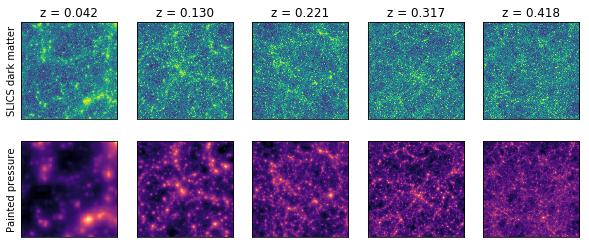

In [27]:
n_plane = len(painted_planes)

fig, ax = plt.subplots(2, n_plane, figsize=(10, 4))

cmap = plt.get_cmap("magma")

for i in range(n_plane):
    delta = np.fromfile(f"../data/training_data/SLICS/delta/{z_SLICS[i]:.3f}delta.dat_bicubic_LOS1097", dtype=np.float32).reshape(7745, -1).T
    delta *= 64
    delta -= delta.min()
    delta = delta[::7,::7]
    
    
    ax[0,i].imshow(delta/(delta+delta.mean()), extent=(0,d_A_SLICS[i]*10/180*pi, 0,d_A_SLICS[i]*10/180*pi))
    ax[1,i].imshow(np.log(painted_planes[i]), cmap=cmap, extent=(0,d_A_SLICS[i]*10/180*pi, 0,d_A_SLICS[i]*10/180*pi))
    
    
#     ax[0,i].axis("off")
#     ax[1,i].axis("off")
    
    
    ax[0,i].set_title(f"z = {z_SLICS[i]:.3f}")

[p.set_xticks([]) for p in ax.flatten()]
[p.set_yticks([]) for p in ax.flatten()]

ax[0,0].set_ylabel("SLICS dark matter")
ax[1,0].set_ylabel("Painted pressure")
fig.savefig("../plots/painted_SLICS.pdf", transparent=True)

# Validation plots

In [37]:
import baryon_painter.utils.data_transforms as data_transforms

n_scale = 1
label_fields = ["pressure"]
redshifts = [0.0, 0.5, 1.0]

split_scale_transform, inv_split_scale_transform = data_transforms.create_split_scale_transform(n_scale=n_scale, 
                                                                                                step_size=8, 
                                                                                                include_original=False,
                                                                                                truncate=2.0)

range_compress_transform, range_compress_inv_transform = data_transforms.create_range_compress_transforms(
                                                                    k_values={"dm" : 1.5, 
                                                                              "pressure" : 4}, 
                                                                    modes={"dm":"x/(1+x)",
                                                                           "pressure" : "log"})

with open(os.path.join("../data/training_data/BAHAMAS/stacks_uncompressed/", "test_files_info.pickle"), "rb") as f:
    test_files_info = pickle.load(f)


transform = data_transforms.chain_transformations([range_compress_transform,
#                                                    split_scale_transform,
                                                   data_transforms.atleast_3d,
                                                  ])

inv_transform = data_transforms.chain_transformations([data_transforms.squeeze,
#                                                        inv_split_scale_transform,
                                                       range_compress_inv_transform,
                                                      ])

test_dataset = datasets.BAHAMASDataset(test_files_info, root_path="../data/training_data/BAHAMAS/stacks_uncompressed/",
                                       redshifts=redshifts,
                                       label_fields=label_fields,
                                       transform=transform,
                                       inverse_transform=inv_transform,
                                       n_feature_per_field=n_scale
                                      )

In [38]:
painter = baryon_painter.painter.CVAEPainter(("../data/checkpoints/no_scale_split_fixed_var_noz2_adalr_net2_new_transform_sample100352_state",
                                              "../data/checkpoints/no_scale_split_fixed_var_noz2_adalr_net2_new_transform_sample100352_meta"),
                                             test_data_set=test_dataset)


CVAE with Type-1 architecture.


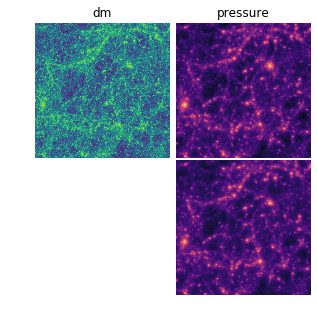

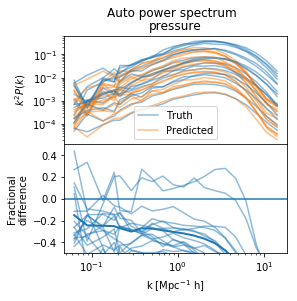

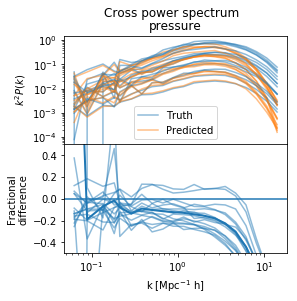

In [41]:
painter.validate(validation_batch_size=16,
                 plot_power_spectra=["auto", "cross"])

In [45]:
test_dataset.n_sample

5120

In [96]:
idx = np.random.randint(0*test_dataset.n_sample, 3*test_dataset.n_sample, 64)

input = []
truth = []
out = []
for i in idx:
    s, _ = test_dataset[i]
    input.append(test_dataset.get_inverse_transforms(i)[0](s[0]))
    truth.append(test_dataset.get_inverse_transforms(i)[1](s[1]))
    z = test_dataset.sample_idx_to_redshift(i)
    out.append(painter.paint(input[-1], z=z))
    
input = np.array(input)
truth = np.array(truth)
out = np.array(out)

/Users/yooken/Research/painting_baryons/baryon_painter/utils/data_transforms.py:86: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(x > -1, mean*k/(1/np.arctanh(x)-1), -mean*k)


In [86]:
import baryon_painter.utils.validation_plotting
importlib.reload(baryon_painter.utils.validation_plotting)

<module 'baryon_painter.utils.validation_plotting' from '/Users/yooken/Research/painting_baryons/baryon_painter/utils/validation_plotting.py'>

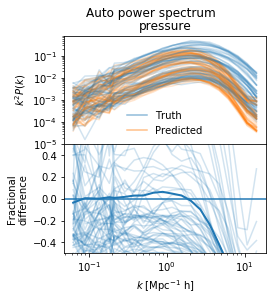

In [99]:
fig, ax = baryon_painter.utils.validation_plotting.plot_power_spectra(output_true=truth[:,None,...], 
                                                           input=input[:,None,...], 
                                                           output_pred=out[:,None,...],
                                                           L=test_dataset.tile_L,
                                                           output_labels=test_dataset.label_fields,
                                                           mode="auto",
#                                                            input_transform=[t[0] for t in inverse_transforms],
#                                                            output_transforms=[t[1:] for t in inverse_transforms],
                                                           n_feature_per_field=test_dataset.n_feature_per_field)

In [100]:
fig.suptitle("Auto-power spectrum z = 0.0 - 1.0")
ax[0,0].set_title("")
fig.savefig("../plots/CVAE_auto_z_all.pdf", transparent=True)

In [27]:
stack_idx = 142
input_tile = test_tiling_dataset.get_input_sample(idx=stack_idx, transform=False)

input_tile = compiled_input_transform(input_tile)
painted_tile = painter.paint(input_tile.reshape(1, *input_tile.shape))

# Old code for getting cut-outs from SLICS massmaps
z: redshift of middle of comoving distance of half box (starting at 0)

In [351]:
def select_cutout(d, shift, size, subtract_mean=False):
    if subtract_mean:
        d_mean = d.astype(np.float64).mean()
    else:
        d_mean = 0
        
    x1 = shift[0]
    y1 = shift[1]
    
    x2 = shift[0] + size
    y2 = shift[1] + size
    
    if x2 < d.shape[0] and y2 < d.shape[1]:
        return d[x1:x2,y1:y2] - d_mean
    elif x2 < d.shape[0] and y2 >= d.shape[1]:
        return np.concatenate((d[x1:x2,y1:], d[x1:x2,:y2-d.shape[1]]), axis=1) - d_mean
    elif x2 >= d.shape[0] and y2 < d.shape[1]:
        return np.concatenate((d[x1:,y1:y2], d[:x2-d.shape[0],y1:y2]), axis=0) - d_mean

shifts = np.loadtxt("../data/training_data/SLICS/random_shift_LOS1097")[::-1]

projection = lambda idx: ["xy", "xz", "yz"][idx%3]
z_idx = 0

pixel_shifts = (shifts[z_idx]*12288).astype(int)
pixel_size = int(d_A_SLICS[z_idx]*10/180*pi/505*12288)

plane = select_cutout(np.fromfile(f"../data/training_data/SLICS/massplanes/{z_SLICS[z_idx]:.3f}proj_half_finer_{projection(z_idx)}.dat_LOS1097", dtype=np.float32)[1:].reshape(4096*3, -1).T,
                      pixel_shifts, pixel_size, subtract_mean=True)

delta = np.fromfile(f"../data/training_data/SLICS/delta/{z_SLICS[z_idx]:.3f}delta.dat_bicubic_LOS1097", dtype=np.float32).reshape(7745, -1).T
delta = delta[::7, ::7]



Text(0.5,1,'Delta-plane z=0.042')

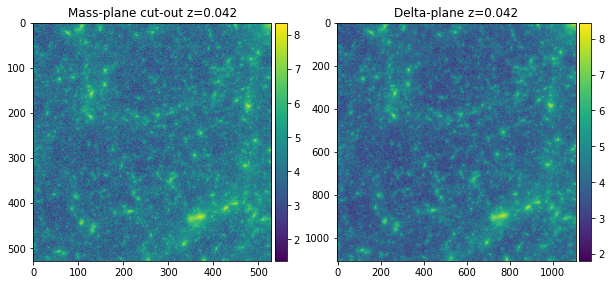

In [353]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

im = ax[0].imshow(np.log(plane+100))
subplot_colorbar(im, ax[0])
ax[0].set_title(f"Mass-plane cut-out z={z_SLICS[z_idx]:.3f}")

im = ax[1].imshow(np.log(delta+100))
subplot_colorbar(im, ax[1])
ax[1].set_title(f"Delta-plane z={z_SLICS[z_idx]:.3f}")


Text(0.5,1,'Histogram')

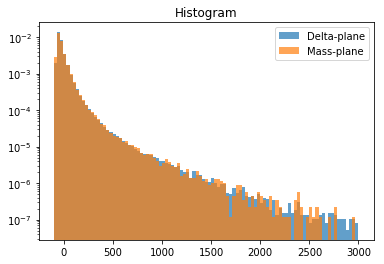

In [354]:
bins = np.linspace(-100, 3000, 100)
_ = plt.hist(delta.flatten(), bins=bins, alpha=0.7, density=True, label="Delta-plane")
_ = plt.hist(plane.flatten(), bins=bins, alpha=0.7, density=True, label="Mass-plane")
plt.legend()
plt.yscale("log")
plt.title("Histogram")